# random forests with pretrained network for feature extraction
## MobileNetV2 with different numbers of learners

In [62]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import DataLoader, ConcatDataset, random_split
from torchvision import datasets, models, transforms
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#from the code by Hishem
def load_mri_data(base_path, batch_size=32):
    train_dir = os.path.join(base_path, 'Training')
    test_dir = os.path.join(base_path, 'Testing')

    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

    total_dataset = ConcatDataset([train_dataset, test_dataset])
    labels_map = {0: 'glioma tumor', 1: 'meningioma tumor', 2: 'no tumor', 3: 'pituitary tumor'}
    return total_dataset, labels_map

def prepare_data_loader(dataset, test_fraction=0.2, batch_size=32):
    total_size = len(dataset)
    test_size = int(total_size * test_fraction)
    train_size = total_size - test_size

    random_seed = 42
    generator = torch.Generator().manual_seed(random_seed)

    train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=generator)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader


# now my code:

def extract_features(model, dataloader):
    model.eval()  # evaluation mode
    features_list = []
    labels_list = []

    with torch.no_grad(): # leave out gradient computation in the loop → less computational memory
        for inputs, labels in tqdm(dataloader, desc="Extracting features"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            # flatten features from (batch_size, channels, height, width) to (batch_size, channels*height*width)
            features_flatten = outputs.view(outputs.size(0), -1)
            features_list.extend(features_flatten.cpu().numpy()) #first move features to cpu so that numpy can use it
            labels_list.extend(labels.cpu().numpy())
    
    return np.array(features_list), np.array(labels_list)

def plot_confusion_matrix(conf_matrix, labels):
    plt.figure(figsize=(6, 4))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    # annotate the cells with the relative values 
    norm_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, f'{norm_conf_matrix[i, j]:.2f}', horizontalalignment="center",
                     color="white" if norm_conf_matrix[i, j] > 0.5 else "black")
    plt.xlabel('predicted label')
    plt.ylabel('true label')
    plt.show()


def train_and_evaluate(n_estimators, X_train, y_train, X_test, y_test):
    print(f"training Random Forest with {n_estimators} trees...")
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=42, n_jobs=-1)
    rf_classifier.fit(X_train, y_train)
    
    # predictions on training set and test set
    y_train_pred = rf_classifier.predict(X_train)
    y_test_pred = rf_classifier.predict(X_test)
    
    # accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    print(f"training accuracy with {n_estimators} trees: {train_accuracy:.3f}")
    print(f"testing accuracy with {n_estimators} trees: {test_accuracy:.3f}")
    
    # confusion matrices
    train_conf_matrix = confusion_matrix(y_train, y_train_pred)
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)

    return n_estimators, train_accuracy, test_accuracy, train_conf_matrix, test_conf_matrix

Loading the data:

In [ ]:
base_path = 'archive/gray_smaller_size/'  
batch_size = 32
total_dataset, labels_map = load_mri_data(base_path, batch_size=batch_size)
train_loader, test_loader = prepare_data_loader(total_dataset, test_fraction=0.2, batch_size=batch_size)

In [ ]:
# loadpretrained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)
# remove the last classification layer to get feature extractor
model = torch.nn.Sequential(*(list(model.children())[:-1])).to(device)

# extract features using the pretrained model
X_train, y_train = extract_features(model, train_loader)
X_test, y_test = extract_features(model, test_loader)

In [ ]:
# train rf for different numbers of weak learners 
n_estimators_list = [16, 32, 64, 128, 256]

results = Parallel(n_jobs=len(n_estimators_list))(
    delayed(train_and_evaluate)(n_estimators, X_train, y_train, X_test, y_test)
    for n_estimators in n_estimators_list
)

# extract results
train_accuracies = [result[1] for result in results]
test_accuracies = [result[2] for result in results]
test_confusion_matrices = [result[4] for result in results]

In [76]:
text = 'randomforests_mobilenetv2'
# saving the data
'''
np.save(text+'n_estimators_list.npy', n_estimators_list)   
np.save(text + 'train_accuracies.npy', train_accuracies)   
np.save(text + 'test_accuracies.npy', test_accuracies)
np.save(text + 'test_confusion_matrices.npy', test_confusion_matrices)
'''

# reading the data from previous run
''' '''
n_estimators_list_loaded = np.load(text+'n_estimators_list.npy')
train_accuracies_loaded = np.load(text+'train_accuracies.npy')
test_accuracies_loaded =  np.load(text+'test_accuracies.npy')
#test_confusion_matrices = np.load(text + 'test_confusion_matrices.npy')


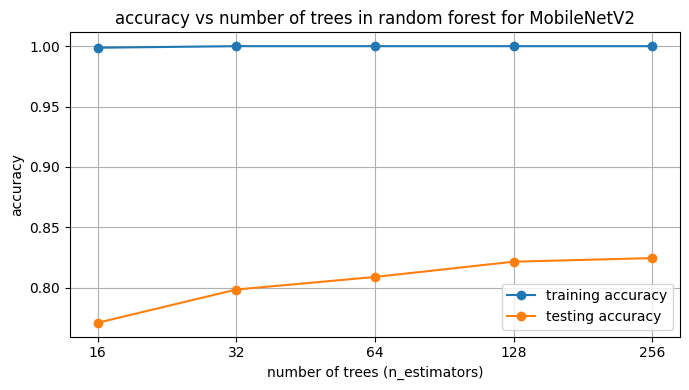

[0.77100372 0.79851301 0.80892193 0.82156134 0.82453532]
training Random Forest with 128 trees...
training accuracy with 128 trees: 1.000
testing accuracy with 128 trees: 0.792
training Random Forest with 256 trees...
training accuracy with 256 trees: 1.000
testing accuracy with 256 trees: 0.804


In [26]:
# plot train & test accuracy
plt.figure(figsize=(7, 4))
plt.plot(n_estimators_list_loaded, train_accuracies_loaded, label='training accuracy', marker='o')
plt.plot(n_estimators_list_loaded, test_accuracies_loaded, label='testing accuracy', marker='o')
plt.xlabel('number of trees (n_estimators)')
plt.ylabel('accuracy')
plt.title('accuracy vs number of trees in random forest'+' for MobileNetV2')

plt.gca().set_xscale('log', base=2)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
plt.legend()
plt.grid(True)
plt.savefig('randomforests_test_training_accuracy_mobilnetv2.png')
plt.tight_layout()
plt.show()

'''
# Print and plot the confusion matrices for the best performing model
best_index = np.argmax(test_accuracies)
best_n_estimators = n_estimators_lis[best_index]
best_test_conf_matrix = test_confusion_matrices[best_index]

print(f"\nBest Model: {best_n_estimators} trees")
plot_confusion_matrix(best_test_conf_matrix, labels_map.values())
'''
print(test_accuracies_loaded)

In [77]:
test_accuracies_mobilenetv2 = test_accuracies_loaded

array([0.77100372, 0.79851301, 0.80892193, 0.82156134, 0.82453532])

In [ ]:
'''
# predictions
print("Evaluating the model...")
y_train_pred = rf_classifier.predict(X_train)
y_test_pred = rf_classifier.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Training Accuracy: {:.3f}%".format(train_accuracy * 100))
print("Testing Accuracy: {:.3f}%".format(test_accuracy * 100))

# confusion matrices
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
class_report = classification_report(y_test, y_test_pred, target_names=labels_map.values())

print("\nTest Confusion Matrix:\n", test_conf_matrix)
print("\nClassification Report:\n", class_report)

print("Plotting Confusion Matrix for Training Data...")
plot_confusion_matrix(train_conf_matrix, labels_map.values())
print("Plotting Confusion Matrix for Test Data...")
plot_confusion_matrix(test_conf_matrix, labels_map.values())

'''

this method took only about 7 min → very fast. 100% accuracy for train and almost 83 % for testing

## now with ResNet50 

In [16]:
# load pretrained resnset50 model
model = models.resnet50(pretrained=True)
# remove the last classification layer to get feature extractor
model = torch.nn.Sequential(*(list(model.children())[:-1])).to(device)

# extract features using the pretrained model
X_train, y_train = extract_features(model, train_loader)
X_test, y_test = extract_features(model, test_loader)

/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extracting features: 100%|██████████████████████| 43/43 [00:52<00:00,  1.22s/it]


In [ ]:
# train rf for different numbers of weak learners 
n_estimators_list = [16, 32, 64, 128, 256]

results = Parallel(n_jobs=len(n_estimators_list))(
    delayed(train_and_evaluate)(n_estimators, X_train, y_train, X_test, y_test)
    for n_estimators in n_estimators_list
)

# extract results
train_accuracies = [result[1] for result in results]
test_accuracies = [result[2] for result in results]
test_confusion_matrices = [result[4] for result in results]

In [78]:
text = 'randomforests_resnet50'
# saving the data
'''
np.save(text+'n_estimators_list.npy', n_estimators_list)   
np.save(text + 'train_accuracies.npy', train_accuracies)   
np.save(text + 'test_accuracies.npy', test_accuracies)
np.save(text + 'test_confusion_matrices.npy', test_confusion_matrices)
'''

# reading the data from previous run
''' '''
n_estimators_list_loaded = np.load(text+'n_estimators_list.npy')
train_accuracies_loaded = np.load(text+'train_accuracies.npy')
test_accuracies_loaded =  np.load(text+'test_accuracies.npy')
#test_confusion_matrices = np.load(text + 'test_confusion_matrices.npy')


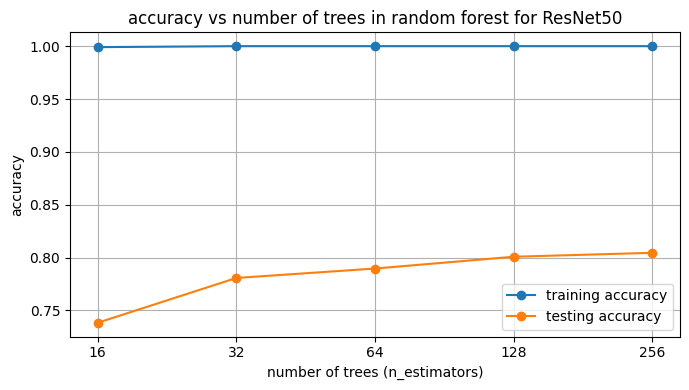

'\n# Print and plot the confusion matrices for the best performing model\nbest_index = np.argmax(test_accuracies)\nbest_n_estimators = n_estimators_list[best_index]\nbest_test_conf_matrix = test_confusion_matrices[best_index]\n\nprint(f"\nBest Model: {best_n_estimators} trees")\nplot_confusion_matrix(best_test_conf_matrix, labels_map.values())\n\nprint(test_accuracies)\n'

In [29]:
# plot train & test accuracy
plt.figure(figsize=(7, 4))
plt.plot(n_estimators_list_loaded, train_accuracies_loaded, label='training accuracy', marker='o')
plt.plot(n_estimators_list_loaded, test_accuracies_loaded, label='testing accuracy', marker='o')
plt.xlabel('number of trees (n_estimators)')
plt.ylabel('accuracy')
plt.title('accuracy vs number of trees in random forest'+' for ResNet50')

plt.gca().set_xscale('log', base=2)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
plt.legend()
plt.grid(True)
plt.savefig('randomforests_test_training_accuracy_resnet50.png')
plt.tight_layout()
plt.show()

'''
# Print and plot the confusion matrices for the best performing model
best_index = np.argmax(test_accuracies)
best_n_estimators = n_estimators_list[best_index]
best_test_conf_matrix = test_confusion_matrices[best_index]

print(f"\nBest Model: {best_n_estimators} trees")
plot_confusion_matrix(best_test_conf_matrix, labels_map.values())

print(test_accuracies)
'''

In [79]:
test_accuracies_resnet50 =test_accuracies_loaded

## now with efficient net

In [31]:
from efficientnet_pytorch import EfficientNet

# load pretrained efficientnet-b0 model
model = EfficientNet.from_pretrained('efficientnet-b0')
model = model.to(device)

# extract features using the pretrained model
X_train, y_train = extract_features(model, train_loader)
X_test, y_test = extract_features(model, test_loader)

# Reshape the extracted features to 2D if needed (in case they are not already flattened)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

Loaded pretrained weights for efficientnet-b0


Extracting features: 100%|██████████████████████| 43/43 [00:29<00:00,  1.46it/s]


In [32]:
# train rf for different numbers of weak learners 
n_estimators_list = [16, 32, 64, 128, 256]

results = Parallel(n_jobs=len(n_estimators_list))(
    delayed(train_and_evaluate)(n_estimators, X_train, y_train, X_test, y_test)
    for n_estimators in n_estimators_list
)

# extract results
train_accuracies = [result[1] for result in results]
test_accuracies = [result[2] for result in results]
test_confusion_matrices = [result[4] for result in results]

In [89]:
text = 'randomforests_efficientnet-b0_'
# saving the data
''' '''
np.save(text+'n_estimators_list.npy', n_estimators_list)   
np.save(text + 'train_accuracies.npy', train_accuracies)   
np.save(text + 'test_accuracies.npy', test_accuracies)
np.save(text + 'test_confusion_matrices.npy', test_confusion_matrices)

train_accuracies_loaded = train_accuracies
test_accuracies_loaded = test_accuracies
n_estimators_list_loaded = n_estimators_list
''' '''

# reading the data from previous run
'''
n_estimators_list_loaded = np.load(text+'n_estimators_list.npy')
train_accuracies_loaded = np.load(text+'train_accuracies.npy')
test_accuracies_loaded =  np.load(text+'test_accuracies.npy')
test_confusion_matrices = np.load(text + 'test_confusion_matrices.npy')
'''
test_accuracies_loaded =  np.load(text+'test_accuracies.npy')

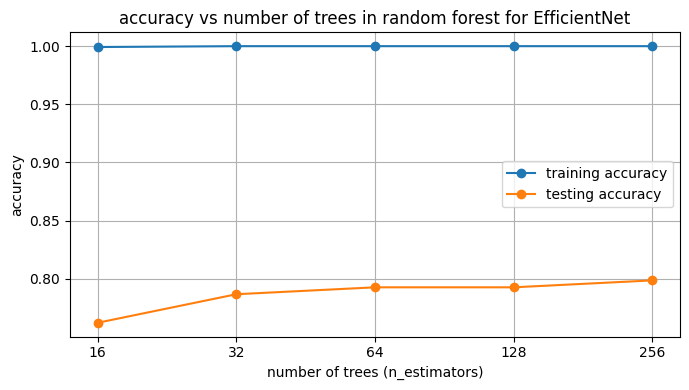


Best Model: 256 trees


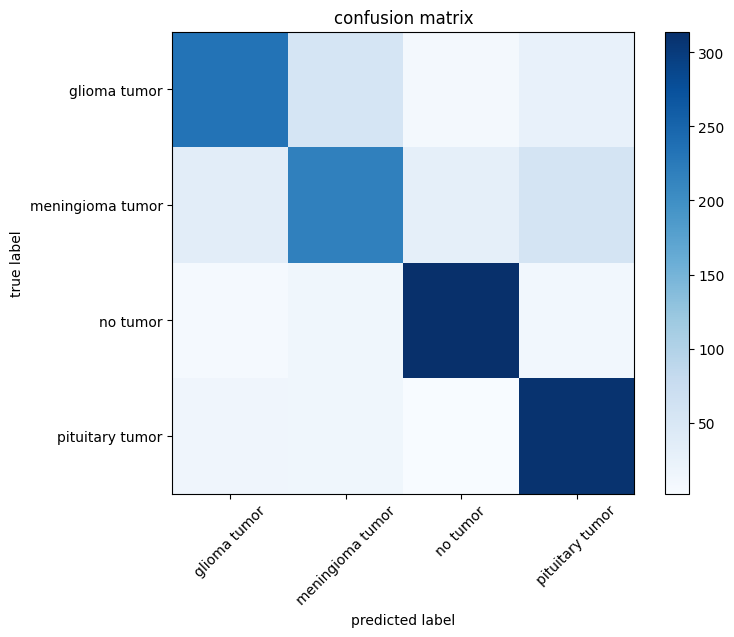

[0.7620817843866171, 0.7866171003717473, 0.7925650557620818, 0.7925650557620818, 0.7985130111524164]
training Random Forest with 16 trees...
training accuracy with 16 trees: 0.999
testing accuracy with 16 trees: 0.762
training Random Forest with 32 trees...
training accuracy with 32 trees: 1.000
testing accuracy with 32 trees: 0.787
training Random Forest with 64 trees...
training accuracy with 64 trees: 1.000
testing accuracy with 64 trees: 0.793
training Random Forest with 128 trees...
training accuracy with 128 trees: 1.000
testing accuracy with 128 trees: 0.793
training Random Forest with 256 trees...
training accuracy with 256 trees: 1.000
testing accuracy with 256 trees: 0.799


In [35]:


# plot train & test accuracy
plt.figure(figsize=(7, 4))
plt.plot(n_estimators_list_loaded, train_accuracies_loaded, label='training accuracy', marker='o')
plt.plot(n_estimators_list_loaded, test_accuracies_loaded, label='testing accuracy', marker='o')
plt.xlabel('number of trees (n_estimators)')
plt.ylabel('accuracy')
plt.title('accuracy vs number of trees in random forest'+' for EfficientNet')

plt.gca().set_xscale('log', base=2)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
plt.legend()
plt.grid(True)
plt.savefig('randomforests_test_training_accuracy_efficientnet-b0.png')
plt.tight_layout()
plt.show()

# Print and plot the confusion matrices for the best performing model
best_index = np.argmax(test_accuracies)
best_n_estimators = n_estimators_list[best_index]
best_test_conf_matrix = test_confusion_matrices[best_index]

print(f"\nBest Model: {best_n_estimators} trees")
plot_confusion_matrix(best_test_conf_matrix, labels_map.values())

print(test_accuracies)


In [85]:
test_accuracies_effi = test_accuracies_loaded

## now with mobilenetv3

In [45]:
# load pretrained mobilnet model
model = models.mobilenet_v3_large(pretrained=True)
# remove the last classification layer to get feature extractor
model = torch.nn.Sequential(*(list(model.children())[:-1])).to(device)

# extract features using the pretrained model
X_train, y_train = extract_features(model, train_loader)
X_test, y_test = extract_features(model, test_loader)

/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extracting features: 100%|██████████████████████| 43/43 [00:16<00:00,  2.60it/s]


In [46]:
# train rf for different numbers of weak learners 
n_estimators_list = [16, 32, 64, 128, 256]

results = Parallel(n_jobs=len(n_estimators_list))(
    delayed(train_and_evaluate)(n_estimators, X_train, y_train, X_test, y_test)
    for n_estimators in n_estimators_list
)

# extract results
train_accuracies = [result[1] for result in results]
test_accuracies = [result[2] for result in results]
test_confusion_matrices = [result[4] for result in results]

In [86]:
text = 'randomforests_mobilenetv3_'
# saving the data
''' '''
np.save(text+'n_estimators_list.npy', n_estimators_list)   
np.save(text + 'train_accuracies.npy', train_accuracies)   
np.save(text + 'test_accuracies.npy', test_accuracies)
np.save(text + 'test_confusion_matrices.npy', test_confusion_matrices)

train_accuracies_loaded = train_accuracies
test_accuracies_loaded = test_accuracies
n_estimators_list_loaded = n_estimators_list
''' '''

# reading the data from previous run
'''
n_estimators_list_loaded = np.load(text+'n_estimators_list.npy')
train_accuracies_loaded = np.load(text+'train_accuracies.npy')
test_accuracies_loaded =  np.load(text+'test_accuracies.npy')
test_confusion_matrices = np.load(text + 'test_confusion_matrices.npy')
'''
test_accuracies_loaded =  np.load(text+'test_accuracies.npy')


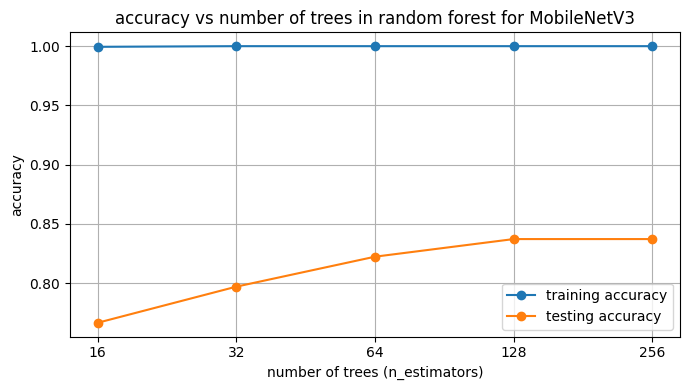


Best Model: 128 trees


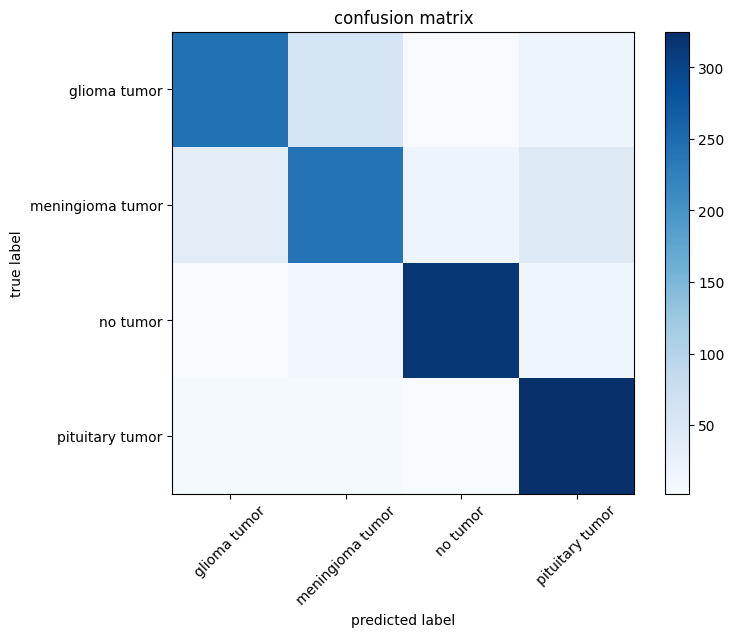

[0.7665427509293681, 0.7970260223048327, 0.8223048327137547, 0.8371747211895911, 0.8371747211895911]
training Random Forest with 16 trees...
training accuracy with 16 trees: 0.999
testing accuracy with 16 trees: 0.769
training Random Forest with 16 trees...
training accuracy with 16 trees: 0.999
testing accuracy with 16 trees: 0.769
training Random Forest with 16 trees...
training accuracy with 16 trees: 0.999
testing accuracy with 16 trees: 0.769
training Random Forest with 16 trees...
training accuracy with 16 trees: 0.999
testing accuracy with 16 trees: 0.769
training Random Forest with 16 trees...
training accuracy with 16 trees: 0.999
testing accuracy with 16 trees: 0.767
training Random Forest with 32 trees...
training accuracy with 32 trees: 1.000
testing accuracy with 32 trees: 0.799
training Random Forest with 32 trees...
training accuracy with 32 trees: 1.000
testing accuracy with 32 trees: 0.799
training Random Forest with 32 trees...
training accuracy with 32 trees: 1.000
t

In [49]:

# plot train & test accuracy
plt.figure(figsize=(7, 4))
plt.plot(n_estimators_list_loaded, train_accuracies_loaded, label='training accuracy', marker='o')
plt.plot(n_estimators_list_loaded, test_accuracies_loaded, label='testing accuracy', marker='o')

plt.xlabel('number of trees (n_estimators)')
plt.ylabel('accuracy')
plt.title('accuracy vs number of trees in random forest'+' for MobileNetV3')

plt.gca().set_xscale('log', base=2)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
plt.legend()
plt.grid(True)
plt.savefig('randomforests_test_training_accuracy_mobilenetv3.png')
plt.tight_layout()
plt.show()

# Print and plot the confusion matrices for the best performing model
best_index = np.argmax(test_accuracies)
best_n_estimators = n_estimators_list[best_index]
best_test_conf_matrix = test_confusion_matrices[best_index]

print(f"\nBest Model: {best_n_estimators} trees")
plot_confusion_matrix(best_test_conf_matrix, labels_map.values())

print(test_accuracies)


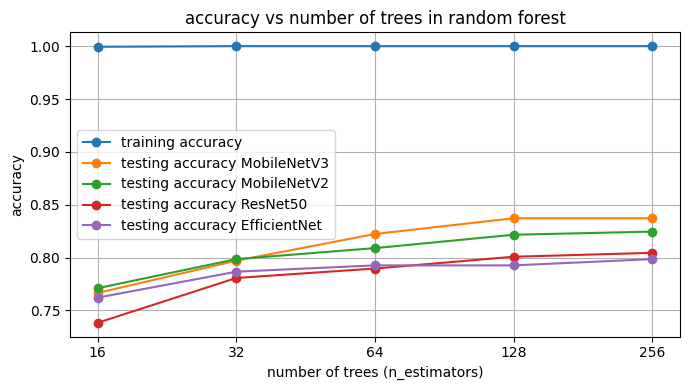

In [88]:
# plot train & test accuracy

plt.figure(figsize=(7, 4))
plt.plot(n_estimators_list_loaded, train_accuracies_loaded, label='training accuracy', marker='o')
plt.plot(n_estimators_list_loaded, test_accuracies_loaded, label='testing accuracy MobileNetV3', marker='o')
plt.plot(n_estimators_list_loaded, test_accuracies_mobilenetv2, label='testing accuracy MobileNetV2', marker='o')
plt.plot(n_estimators_list_loaded, test_accuracies_resnet50, label='testing accuracy ResNet50', marker='o')
plt.plot(n_estimators_list_loaded, test_accuracies_effi, label='testing accuracy EfficientNet', marker='o')

plt.xlabel('number of trees (n_estimators)')
plt.ylabel('accuracy')
plt.title('accuracy vs number of trees in random forest')

plt.gca().set_xscale('log', base=2)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
plt.legend()
plt.grid(True)
plt.savefig('randomforests_test_training_accuracy_allmodels.png')
plt.tight_layout()
plt.show()

best performance so far

# study of hyperparameters for Random Forests
minimum node size maybe 2 (as default) , 4, 8, 16, 32, 64, 128
see the Elements of statistical learning:  15.3.4 Random Forests and Overfitting

Use only 128 estimators to reduce the computation time

In [54]:
from sklearn.model_selection import StratifiedKFold

def evaluate_single_hyperparameter(train_index, val_index, min_samples_split, X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    rf_classifier = RandomForestClassifier(n_estimators=128, random_state=42, n_jobs=-1, min_samples_split=min_samples_split)
    rf_classifier.fit(X_train_fold, y_train_fold)
    val_preds = rf_classifier.predict(X_val_fold)
    val_accuracy = accuracy_score(y_val_fold, val_preds)
    
    return val_accuracy

def evaluate_hyperparameters(X_train, y_train, min_samples_split_values, n_splits=5, n_jobs=-1):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_scores = [[] for _ in range(len(min_samples_split_values))]

    # with tqdm for progress bar
    for train_index, val_index in tqdm(skf.split(X_train, y_train), total=n_splits, desc="CV Folds"):
        parallel_results = Parallel(n_jobs=n_jobs)(
            delayed(evaluate_single_hyperparameter)(train_index, val_index, min_samples_split, X_train, y_train)
            for min_samples_split in min_samples_split_values
        )

        for i, score in enumerate(parallel_results):
            fold_scores[i].append(score)

    mean_cv_scores = [np.mean(scores) for scores in fold_scores]
    return mean_cv_scores


In [55]:
min_samples_split_values = [2, 4, 8, 16, 32, 64, 128]

# perform cross-validation for each min_samples_split value with parallelization
mean_cv_scores = evaluate_hyperparameters(X_train, y_train, min_samples_split_values, n_splits=5, n_jobs=-1)

CV Folds: 100%|███████████████████████████████████| 5/5 [04:20<00:00, 52.04s/it]


In [58]:
text = 'randomforests_mobilenetv3_CV_128learners'
np.save(text+'mean_cv_scores.npy', mean_cv_scores)   
np.save(text + 'min_samples_split_values.npy', min_samples_split_values)
 

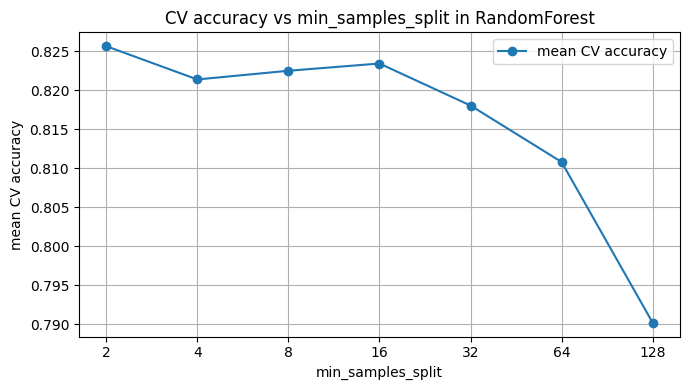

[np.float64(0.8256819680166234), np.float64(0.821408773510336), np.float64(0.8225252232381701), np.float64(0.8234551090216871), np.float64(0.8180639115262345), np.float64(0.8108148408942644), np.float64(0.7901871852488498)]


In [56]:
# Plot the results
plt.figure(figsize=(7, 4))
plt.plot(min_samples_split_values, mean_cv_scores, label='mean CV accuracy', marker='o')
plt.xlabel('min_samples_split')
plt.ylabel('mean CV accuracy')
plt.title('CV accuracy vs min_samples_split in random forest')
plt.legend()
plt.grid(True)
plt.gca().set_xscale('log', base=2)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
plt.savefig('randomforests_accuracy_differentmiinsamplessplit_mobilenetv3.png')
plt.tight_layout()
plt.show()

print(mean_cv_scores)

So, we can observe that the accuracy is the highest when using a very complex tree in the random forests step. This is reasonable, as our classification task is of a complex nature.

# now final result with different numbers of estimators

In [68]:

def evaluate_single_hyperparameter_n_estimators(train_index, val_index, n_estimators, X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=42, n_jobs=-1)
    rf_classifier.fit(X_train_fold, y_train_fold)
    val_preds = rf_classifier.predict(X_val_fold)
    val_accuracy = accuracy_score(y_val_fold, val_preds)
    
    return val_accuracy


def evaluate_hyperparameters_n_estimators(X_train, y_train, min_samples_split_values, n_splits=5, n_jobs=-1):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_scores = [[] for _ in range(len(min_samples_split_values))]

    # with tqdm for progress bar
    for train_index, val_index in tqdm(skf.split(X_train, y_train), total=n_splits, desc="CV Folds"):
        parallel_results = Parallel(n_jobs=n_jobs)(
            delayed(evaluate_single_hyperparameter_n_estimators)(train_index, val_index, min_samples_split, X_train, y_train)
            for min_samples_split in min_samples_split_values
        )

        for i, score in enumerate(parallel_results):
            fold_scores[i].append(score)

    mean_cv_scores = [np.mean(scores) for scores in fold_scores]
    return mean_cv_scores


estimator_nums = [50, 100, 150, 200, 250, 300, 350, 400]

# perform cross-validation for each min_samples_split value with parallelization
mean_cv_scores = evaluate_hyperparameters_n_estimators(X_train, y_train, estimator_nums, n_splits=5, n_jobs=-1)

CV Folds: 100%|██████████████████████████████████| 5/5 [12:15<00:00, 147.03s/it]


In [71]:
text = 'randomforests_mobilenetv3_CV_differentlearners'
np.save(text+'mean_cv_scores.npy', mean_cv_scores)   
np.save(text + 'min_samples_split_values.npy', min_samples_split_values)
 

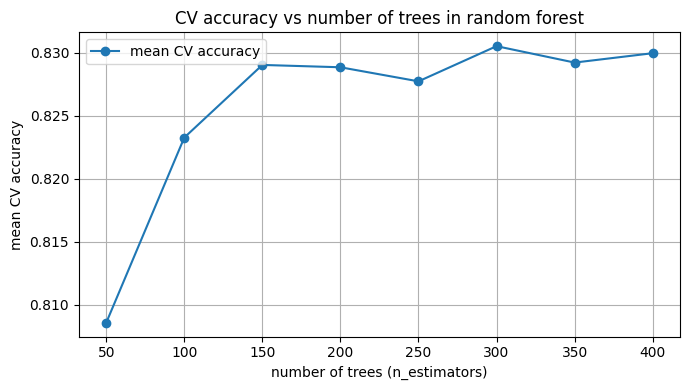

[np.float64(0.8085845302074812), np.float64(0.8232669918160387), np.float64(0.8290275203390942), np.float64(0.8288421644869232), np.float64(0.8277264050974585), np.float64(0.8305158898634166), np.float64(0.8292146020371887), np.float64(0.8299575787072033)]


In [72]:
# Plot the results
plt.figure(figsize=(7, 4))
plt.plot(estimator_nums, mean_cv_scores, label='mean CV accuracy', marker='o')
plt.xlabel('number of trees (n_estimators)')
plt.ylabel('mean CV accuracy')
plt.title('CV accuracy vs number of trees in random forest')
plt.legend()
plt.grid(True)
#plt.gca().set_xscale('log', base=2)
#plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
plt.savefig('randomforests_accuracy_differentnumofestimators_mobilenetv3.png')
plt.tight_layout()
plt.show()

print(mean_cv_scores)

## final result

In [73]:
n_estimators = 300
results = train_and_evaluate(n_estimators, X_train, y_train, X_test, y_test)
best_n_estimators, train_accuracy, test_accuracy, train_conf_matrix, test_conf_matrix = results


training Random Forest with 300 trees...
training accuracy with 300 trees: 1.000
testing accuracy with 300 trees: 0.843


In [74]:
print(f"\nModel trained with {best_n_estimators} trees")
print(f"Training Accuracy: {train_accuracy:.3f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")


Model trained with 300 trees
Training Accuracy: 1.000
Testing Accuracy: 0.8431


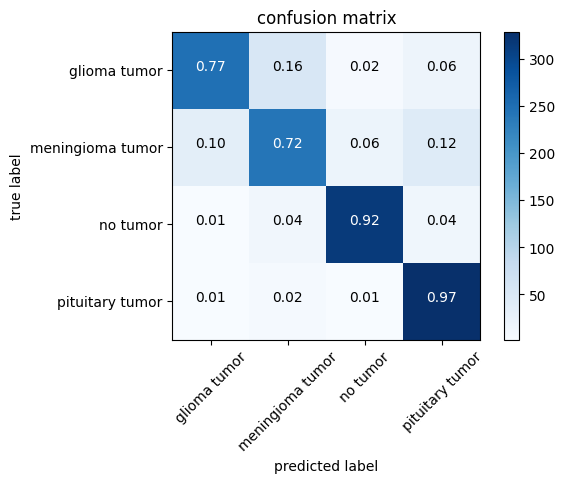

In [75]:
plot_confusion_matrix(test_conf_matrix, labels_map.values())

 we get an accuracy of 0.8431 for our final model using random forests and the features by a pretrained model.